# Import Torch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training & Test Data

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.87MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 55.1MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.9MB/s]


# Create data loaders

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Creating Models

In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 250),
            nn.ReLU(),
            nn.Linear(250, 125),
            nn.ReLU(),
            nn.Linear(125, 75),
            nn.ReLU(),
            nn.Linear(75, 10),
            
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=125, bias=True)
    (3): ReLU()
    (4): Linear(in_features=125, out_features=75, bias=True)
    (5): ReLU()
    (6): Linear(in_features=75, out_features=10, bias=True)
  )
)


# Code to Check Dataset Size

In [5]:
# Print total number of samples in training and test datasets
print(f"Total training samples: {len(training_data)}")
print(f"Total test samples: {len(test_data)}")
print(f"Total dataset size: {len(training_data) + len(test_data)}")

Total training samples: 60000
Total test samples: 10000
Total dataset size: 70000


# Display Data

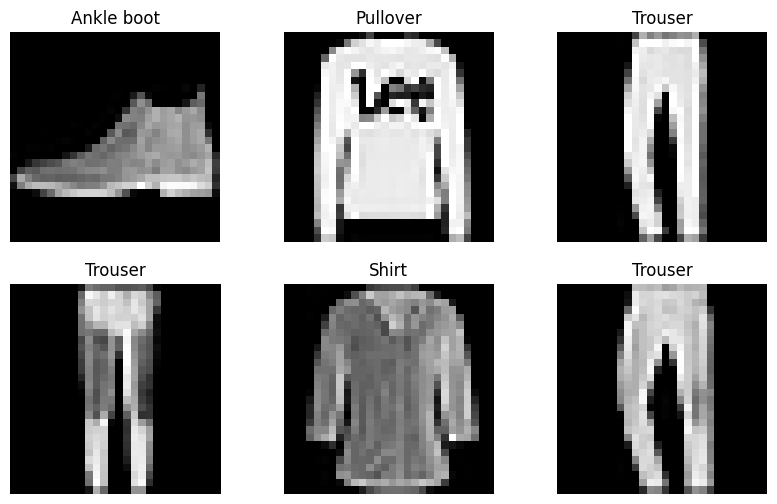

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define class labels for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get one batch of images and labels from the test dataloader
images, labels = next(iter(test_dataloader))

# Plot the first 6 images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # Convert tensor to numpy and remove channel dimension
    image = images[i].numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.show()

# Optimizing the Model Parameters

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Train Function

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Test Function

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Train Data

In [10]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.289437  [   64/60000]
loss: 2.291673  [ 6464/60000]
loss: 2.295586  [12864/60000]
loss: 2.308474  [19264/60000]
loss: 2.301697  [25664/60000]
loss: 2.296179  [32064/60000]
loss: 2.297818  [38464/60000]
loss: 2.289080  [44864/60000]
loss: 2.288900  [51264/60000]
loss: 2.305905  [57664/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.288718 

Epoch 2
-------------------------------
loss: 2.278363  [   64/60000]
loss: 2.281529  [ 6464/60000]
loss: 2.281409  [12864/60000]
loss: 2.294688  [19264/60000]
loss: 2.288821  [25664/60000]
loss: 2.278497  [32064/60000]
loss: 2.284573  [38464/60000]
loss: 2.273126  [44864/60000]
loss: 2.271765  [51264/60000]
loss: 2.285030  [57664/60000]
Test Error: 
 Accuracy: 14.1%, Avg loss: 2.270531 

Epoch 3
-------------------------------
loss: 2.262837  [   64/60000]
loss: 2.267797  [ 6464/60000]
loss: 2.260526  [12864/60000]
loss: 2.275213  [19264/60000]
loss: 2.270131  [25664/60000]
loss: 2.249679  [32064/600